# Exploratory Data Analysis and Feature Engineering

To train a model, the dataset must follow two fundamental rules: all data must be numeric and there can't be any missing values. 
We must derive numeric features from the nonnumeric features such as strings, dates, and categorical variables.
Or, we can simply delete the nonnumeric features.
Even with purely numeric data, there is potential cleanup work to do. 
The data could have outliers, errors, or contradictory information.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
    
from sklearn.metrics import mean_absolute_error       
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

In [2]:
plt.style.use('ggplot')

color_palette = {
     'crimson': '#a50026', 
     'red': '#d73027',
     'redorange': '#f46d43', 
     'orange': '#fdae61',
     'yellow': '#fee090', 
     'sky': '#e0f3f8',
     'babyblue': '#abd9e9', 
     'lightblue': '#74add1',
     'blue': '#4575b4', 
     'purple': '#313695'
}

In [3]:
PATH_CLEANED = '../data/rent.csv'
PATH_RAW     = '../data/rent-raw.json'

In [4]:
!wc -l {PATH_CLEANED}
!du -h {PATH_CLEANED}
!du -h {PATH_RAW}

48301 ../data/rent.csv
1,3M	../data/rent.csv
68M	../data/rent-raw.json


## A.1. Importing Data

In [5]:
dataset = pd.read_json(path_or_buf = PATH_RAW)
dataset.head(n = 3) # shows first 3 rows

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level
4,1.0,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"[Dining Room, Pre-War, Laundry in Building, Di...",40.7108,7170325,-73.9539,a10db4590843d78c784171a107bdacb4,[https://photos.renthop.com/2/7170325_3bb5ac84...,2400,145 Borinquen Place,medium
6,1.0,2,b8e75fc949a6cd8225b455648a951712,2016-06-01 05:44:33,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,East 44th,"[Doorman, Elevator, Laundry in Building, Dishw...",40.7513,7092344,-73.9722,955db33477af4f40004820b4aed804a0,[https://photos.renthop.com/2/7092344_7663c19a...,3800,230 East 44th,low
9,1.0,2,cd759a988b8f23924b5a2058d5ab2b49,2016-06-14 15:19:59,**FLEX 2 BEDROOM WITH FULL PRESSURIZED WALL**L...,East 56th Street,"[Doorman, Elevator, Laundry in Building, Laund...",40.7575,7158677,-73.9625,c8b10a317b766204f08e613cef4ce7a0,[https://photos.renthop.com/2/7158677_c897a134...,3495,405 East 56th Street,medium


We see a bunch of nonnumeric fields, including some columns that actually look like lists of things packed together into a single string.

In [6]:
memory_series = dataset.memory_usage(deep = True) / (1024 * 1024) # shows size in MB

dataset.info()
display(memory_series)
print(f'Total memory usage: {memory_series.sum():.2f} MB')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49352 entries, 4 to 124009
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bathrooms        49352 non-null  float64
 1   bedrooms         49352 non-null  int64  
 2   building_id      49352 non-null  object 
 3   created          49352 non-null  object 
 4   description      49352 non-null  object 
 5   display_address  49352 non-null  object 
 6   features         49352 non-null  object 
 7   latitude         49352 non-null  float64
 8   listing_id       49352 non-null  int64  
 9   longitude        49352 non-null  float64
 10  manager_id       49352 non-null  object 
 11  photos           49352 non-null  object 
 12  price            49352 non-null  int64  
 13  street_address   49352 non-null  object 
 14  interest_level   49352 non-null  object 
dtypes: float64(3), int64(3), object(9)
memory usage: 6.0+ MB


Index               0.376526
bathrooms           0.376526
bedrooms            0.376526
building_id         3.943884
created             3.576996
description        31.572424
display_address     3.323063
features            5.109459
latitude            0.376526
listing_id          0.376526
longitude           0.376526
manager_id          4.188850
photos              5.047096
price               0.376526
street_address      3.468158
interest_level      2.859732
dtype: float64

Total memory usage: 65.73 MB


## A.2. Training and Evaluating an Initial Model

In [7]:
X, y = dataset[['bathrooms', 'bedrooms', 'longitude', 'latitude']], dataset['price']
X = X.reset_index(drop = True)

Because models cannot handle missing values, another standard check is to see if there are missing values in the dataset.

In [8]:
X.isnull().any()

bathrooms    False
bedrooms     False
longitude    False
latitude     False
dtype: bool

Next, we train the model and try to assess if there is a relationship to capture.

A perfect training $R^2$ score is $1.0$, meaning that the model perfectly recalls the training data. 
An score of $0$ means the model performs no better than always just returning the average price. 
Unfortunately, a high training score (low error) doesn't tell us much. 
A high score just means that it's possible there is a relationship between features and target and captured by the model. 
If, however, we can't get a high score, it's an indication that there is no relationship or the model is simply unable to capture it. 
Random Forests are very powerful and can capture relationships even between random variables, so expect RF training scores to be high.

Think about the score as measuring how well our model performs compared to a trivial model that always returns the average of the target (apartment price) for any requested prediction.
Just remember that $1.0$ means perfect and $0.0$ means no better than returning the average value.

In [9]:
rf_model = RandomForestRegressor(n_jobs = -1)
rf_model.fit(X = X, y = y)

print(f'R^2 score: {rf_model.score(X = X, y = y)}')

R^2 score: 0.8649317768028245


However, we care about the prediction error on validation or test vectors, not the training error.
However, RFs can efficiently estimate the prediction error while training the model, completely avoiding the need for separate validation sets. 
The error score is called the out-of-bag score and is the typical metric computed.
Recall that RFs are a collection of decision trees, each of which is trained on a subset of the training data. 
The *out-of-bag (OOB)* score looks at the prediction accuracy for a particular record using only those trees that did not train on that record. 
Statisticians have shown that the out-of-bag score gives an excellent estimate of a model's generality, its true prediction error.

The out-of-bag score is still not free computationally and we have to ask for the computation with an argument, `oob_score = True`, to the constructor of the RF. 
Here's how to train a model that computes and prints the OOB score.

In [10]:
rf_model = RandomForestRegressor(n_jobs = -1, oob_score = True)
rf_model.fit(X = X.values, y = y.values)

print(f'R^2 score: {rf_model.score(X = X.values, y = y.values)}, OOB score: {rf_model.oob_score_}')

R^2 score: 0.874619321455505, OOB score: -0.01280305382316671


That score is terrible, approximately as bad as just predicting the average apartment rent price.
Let's verify that the mean absolute error (MAE) in dollars is also terrible.

In [11]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size = 0.2)

rf_model = RandomForestRegressor(n_jobs = -1, oob_score = True)
rf_model.fit(X = X_train.values, y = y_train)

predictions = rf_model.predict(X = X_validation.values)
absolute_errors = np.round(np.abs(np.subtract(predictions, y_validation)), decimals = 2)

print(f'Highest Absolute Errors: {list(np.sort(absolute_errors)[-5:])}')
print(f'Mean Absolute Error: {mean_absolute_error(y_validation, predictions):.2f}$')

Highest Absolute Errors: [48098.44, 53483.24, 108157.0, 109449.17, 447829.8]
Mean Absolute Error: 424.48$


This behavior is consistent with the low OOB score coming from the RF, indicating a model trained on the raw data set gets poor results.

## A.3. Exploring Data

The general concept of exploring the dataset is called *exploratory data analysis (EDA)*. 
We're going to explore the data with the explicit purpose of finding anomalies. 
The focus of our model is on typically-priced apartments and only within New York City, which means we're going to look for extreme rent values and apartments outside of New York City.

For the apartment data, it's safe to say that an apartment for less than $\$1,000$ in New York City is probably missing some key elements like windows and doors, so that should be our lowest price. 
At the high-end, let's call $\$10,000$ outside the range of "reasonably priced".

In [12]:
data = dataset[['bathrooms', 'bedrooms', 'longitude', 'latitude', 'price']]
data.describe()

,bathrooms,bedrooms,longitude,latitude,price
count,49352.00000,49352.000000,49352.000000,49352.000000,4.935200e+04
mean,1.21218,1.541640,-73.955716,40.741545,3.830174e+03
std,0.50142,1.115018,1.177912,0.638535,2.206687e+04
min,0.00000,0.000000,-118.271000,0.000000,4.300000e+01
25%,1.00000,1.000000,-73.991700,40.728300,2.500000e+03
50%,1.00000,1.000000,-73.977900,40.751800,3.150000e+03
75%,1.00000,2.000000,-73.954800,40.774300,4.100000e+03
max,10.00000,8.000000,0.000000,44.883500,4.490000e+06


A number of anomalies pop out from the minimum and maximum for each column.
There's a place with $10$ bathrooms and another with $8$ bedrooms. 
There is a reference to longitude $0$, which is the prime meridian (Greenwich, England), and a reference to latitude zero, the equator. 
Oh, and let's not forget the apartment that costs $\$4,490,000$ per month or place that costs $\$43$ per month.

Values that are very different in magnitude from the others in the feature or target space (range) are called *outliers*. 
Outliers could be the result of noise, but some data sets have outliers that are correct values, as is the case here. 
In New York City, it's certain that there are some hyper-expensive apartments.

In [13]:
# shows 5 highest renting prices in the dataset
data['price'].sort_values(ascending = False).head(n = 5)

32611     4490000
12168     1150000
57803     1070000
55437     1070000
123877     135000
Name: price, dtype: int64

Another exploratory technique is to ask pandas for the count of each unique value in a particular column, such as the counts of apartments with specific numbers of bathrooms and bedrooms.

0     9475
1    15752
2    14623
3     7276
4     1929
5      247
6       46
7        2
8        2
Name: bedrooms, dtype: int64

0.0       313
1.0     39422
1.5       645
2.0      7660
2.5       277
3.0       745
3.5        70
4.0       159
4.5        29
5.0        20
5.5         5
6.0         4
6.5         1
7.0         1
10.0        1
Name: bathrooms, dtype: int64

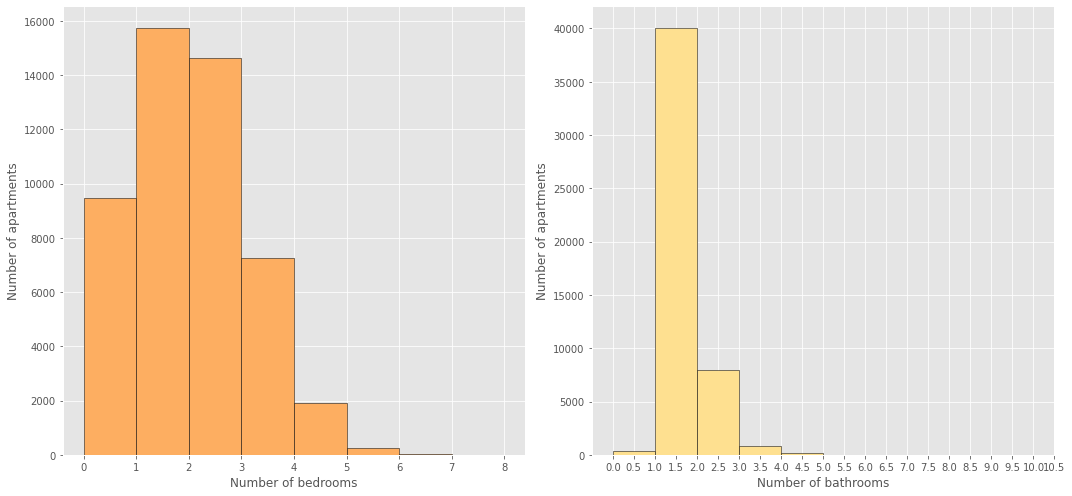

In [14]:
display(data['bedrooms'].value_counts().sort_index(), data['bathrooms'].value_counts().sort_index())

figure, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 7))

axes[0].hist(data['bedrooms'], bins = 8, color = color_palette['orange'], edgecolor = 'black')
axes[0].set_xticks(np.arange(start = 0, stop = 9, step = 1))
axes[0].set_xlabel('Number of bedrooms')
axes[0].set_ylabel('Number of apartments')

axes[1].hist(data['bathrooms'], bins = 10, color = color_palette['yellow'], edgecolor = 'black')
axes[1].set_xticks(np.arange(start = 0, stop = 11, step = .5))
axes[1].set_xlabel('Number of bathrooms')
axes[1].set_ylabel('Number of apartments')

plt.tight_layout()
plt.show()

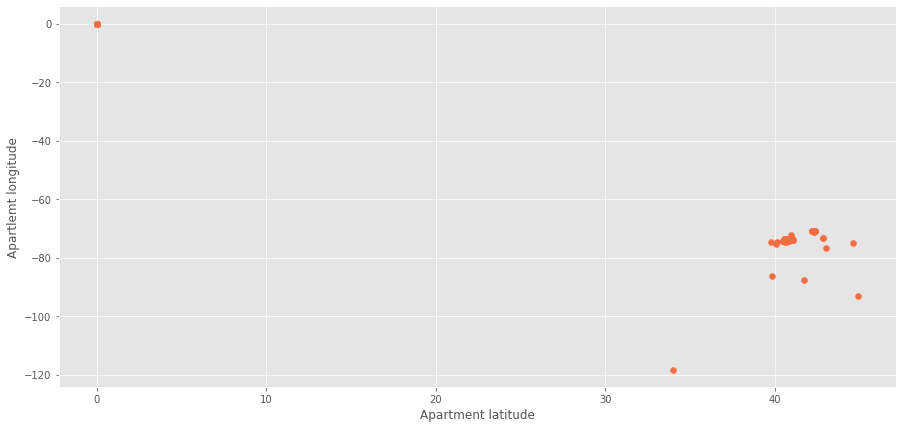

In [15]:
figure, axes = plt.subplots(figsize = (15, 7))
axes.scatter(data['latitude'], data['longitude'], color = color_palette['redorange'])

axes.set_xlabel('Apartment latitude')
axes.set_ylabel('Apartlemt longitude')

plt.show()

From this chart we see that we have some inconsistent information regarding apartment location.
It seems that some apartments are outside of New York City, and additonally some are on the (0, 0) coordinate.

Furthermore, noise and outliers are potential problems because they can lead to inconsistencies. An inconsistency is a set of similar or identical feature vectors with much different target values.

In [16]:
outliers = data[
    (data['latitude'] > 40.764) & (data['latitude'] < 40.7678) & 
    (data['longitude'] >= -73.9844) & (data['longitude'] <= -73.9842) &
    (data['bathrooms'] == 1) & (data['bedrooms'] == 1)
]

outliers.sort_values(by = 'price', axis = 'rows')

,bathrooms,bedrooms,longitude,latitude,price
78664,1.0,1,-73.9843,40.7648,2300
37413,1.0,1,-73.9843,40.7652,2400
23107,1.0,1,-73.9843,40.7652,3350
97552,1.0,1,-73.9843,40.7652,3400
55437,1.0,1,-73.9844,40.7676,1070000
57803,1.0,1,-73.9844,40.7676,1070000


Those ridiculously-priced apartments could be errors or simply outliers, but no matter how powerful a machine learning model is, such inconsistent data leads to inaccurate predictions. 
RFs predict the average price for all apartments whose features cluster them together, and as such they are heavily affected by outliers. 

## A.4. Denoising

To improve data quality we are going to:

  1. Clip the rent prices (remove the lowest and the highest 1%)
  
  2. Remove apartments located on Equator or Greenwich
  
  3. Remove apartments outside New York City

In [17]:
# 1. clip the rent prices
low, high = np.percentile(a = data['price'], q = (1, 99))
data = data[(data['price'] > low) & (data['price'] < high)]

In [18]:
# 2. remove apartments located on Equator or Greenwich
mask = (data['latitude'] != 0) & (data['longitude'] != 0)
data = data[mask]

In [19]:
# 3. remove apartments outside New York City
data = data[
    (data['latitude'] > 40.55) & (data['latitude'] < 40.94) &                
    (data['longitude']>-74.1) & (data['longitude']<-73.67)
]

## A.5. Comparing Models Trained on Denoised Data

Now, we are going to train the model using the denoised dataset.

In [20]:
X, y = data.drop('price', axis = 1), data['price']

rf_model = RandomForestRegressor(n_jobs = -1, oob_score = True)
rf_model.fit(X = X.values, y = y)

print(f'R^2 score: {rf_model.score(X = X.values, y = y)}, OOB score: {rf_model.oob_score_}')

R^2 score: 0.9524820862771973, OOB score: 0.8751803143424622


Great! We've now got a prediction model that gets a decent estimated prediction error.
The OOB score tells us estimation of the validation error. 
So, let's check that by splitting the dataset into training and validation datasets.

In [21]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size = 0.2)

rf_model = RandomForestRegressor(n_jobs = -1, oob_score = True)
rf_model.fit(X = X_train.values, y = y_train)

predictions = rf_model.predict(X = X_validation.values)
absolute_errors = np.round(np.abs(np.subtract(predictions, y_validation)), decimals = 2)

print(f'Highest Absolute Errors: {list(np.sort(absolute_errors)[-5:])}')
print(f'Mean Absolute Error: {mean_absolute_error(y_validation, predictions):.2f}$')
print(f'R^2 score: {rf_model.score(X = X_validation.values, y = y_validation)}')

Highest Absolute Errors: [5653.5, 5702.83, 5758.08, 5758.08, 6335.82]
Mean Absolute Error: 315.83$
R^2 score: 0.866050105771832


The OOB score is pretty good as it's close to 1.0. 
(Recall that a score of 0 indicates our model does know better than simply guessing the average rent price for all apartments and 1.0 means a perfect predictor of rent price.)
Finally, let's calculate feature importances.

In [22]:
def calculate_feature_importances(model, X, y, feature_names, n_repeats = 10):
    
    importances = permutation_importance(model, X = X, y = y, n_repeats = n_repeats, n_jobs = -1)

    importances = pd.DataFrame(
        data    = np.hstack((importances['importances_mean'].reshape(-1, 1), importances['importances_std'].reshape(-1, 1))), 
        index   = feature_names,
        columns = ['importances_mean', 'importances_std']
    )

    return importances.sort_values(by = 'importances_mean', axis = 0, ascending = False)

def plot_importances(importances):
    
    figure, axes = plt.subplots(figsize = (15, 8))

    axes.bar(
        x = importances.index, 
        height = importances['importances_mean'],
        width = 0.4,
        color = color_palette['orange'],
        edgecolor = 'black'
    )

    for index, value in enumerate(importances['importances_mean']):
        axes.text(index - 0.06, value + 0.01, str(round(value,2)), fontweight = 'bold')

    axes.set_ylim(bottom = 0, top = 1)
    axes.set_ylabel('Mean accuracy decrease', fontdict = {'fontsize': 14})
    axes.set_title('Feature importances using permutation on full model', fontdict = {'fontsize': 14})

    plt.show()

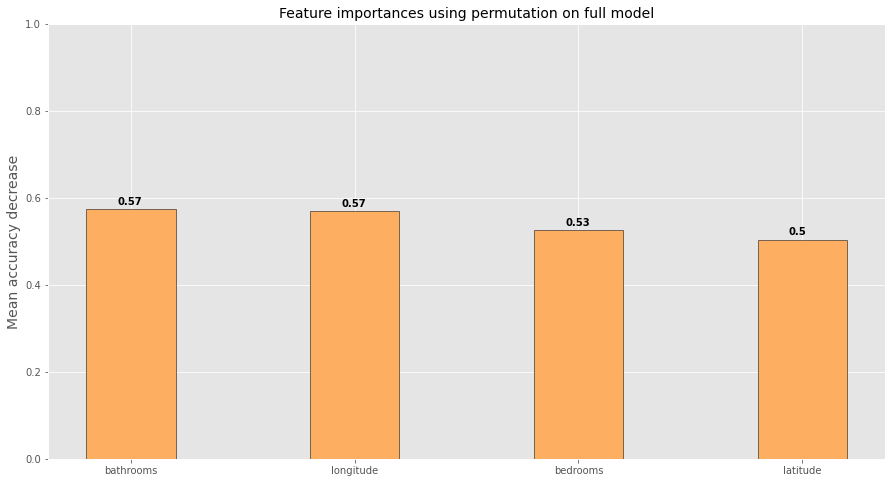

In [23]:
importances = calculate_feature_importances(rf_model, X.values, y, X.columns)
plot_importances(importances)

It seems that OOB score indeed provides a correct estimation of error on the validation dataset without actually using it.

## A.6. Dealing with Categorical Features

Above, we denoised the dataset by doing the following:

  1. Clip the rent prices (remove the lowest and the highest 1%)
  
  2. Remove apartments located on Equator or Greenwich
  
  3. Remove apartments outside New York City
  
Let's apply that on the entire dataset.

In [24]:
# 1. clip the rent prices (remove the lowest and the highest 1%)
low, high = np.percentile(a = dataset['price'], q = (1, 99))
dataset = dataset[(dataset['price'] > low) & (dataset['price'] < high)]

# 2. remove apartments located on Equator or Greenwich
mask = (dataset['latitude'] != 0) & (dataset['longitude'] != 0)
dataset = dataset[mask]

# 3. remove apartments outside New York City
dataset = dataset[
    (dataset['latitude'] > 40.55) & (dataset['latitude'] < 40.94) &                
    (dataset['longitude']>-74.1) & (dataset['longitude']<-73.67)
]

dataset = dataset.reset_index(drop = True)

The `interest_level` feature is a categorical variable that seems to encode interest in an apartment, no doubt taken from webpage activity logs. 
It's a categorical variable because it takes on values from a finite set of choices: `low`, `medium`, and `high`. More specifically, `interest_level` is an ordinal categorical variable, which means that the values can be ordered even if they are not actual numbers.

In [25]:
dataset['interest_level'] = dataset['interest_level'].replace(to_replace = {'low': 1, 'medium': 2, 'high': 3})
dataset['interest_level'] = dataset['interest_level'].astype(dtype = np.int8)

dataset['interest_level'].value_counts()

1    33627
2    11111
3     3555
Name: interest_level, dtype: int64

Ordinal categorical variables are simple to encode numerically. 
Unfortunately, there's another kind of categorical variable called a nominal variable for which there is no meaningful order between the category values (e.g `manager_id`, `building_id`, etc.).
Without an order between categories, it's hard to encode nominal variables as numbers in a meaningful way, particularly when there are very many category values.

We will apply two techniques to encode nominal categorical variables:

  1.  Label encoding simply converts each category to a numeric value, while ignoring the fact that the categories are not really ordered.
  
  2. Frequency encoding converts categories to the frequencies with which they appear in the training.

In [26]:
# label encoding
display((dataset['display_address'].unique().shape, dataset['building_id'].unique().shape))

dataset['display_address'] = dataset['display_address'].astype('category').cat.codes
dataset['building_id'] =  dataset['building_id'].astype('category').cat.codes

((8546,), (7298,))

In [27]:
# frequency encoding
display(dataset['manager_id'].unique().shape)

mapper = dataset['manager_id'].value_counts()
dataset['manager_id'] = dataset['manager_id'].replace(to_replace = mapper).astype(dtype = np.int16)

(3422,)

In [28]:
X, y = dataset[['bedrooms', 'bathrooms', 'latitude', 'longitude', 'display_address', 'building_id', 'interest_level']], dataset['price']

rf_regressor = RandomForestRegressor(n_jobs = -1, oob_score = True)
rf_regressor.fit(X = X.values, y = y)

print(f'R^2 score: {rf_regressor.score(X = X.values, y = y)}, OOB score: {rf_regressor.oob_score_}')

R^2 score: 0.968321483873883, OOB score: 0.8726454123909572


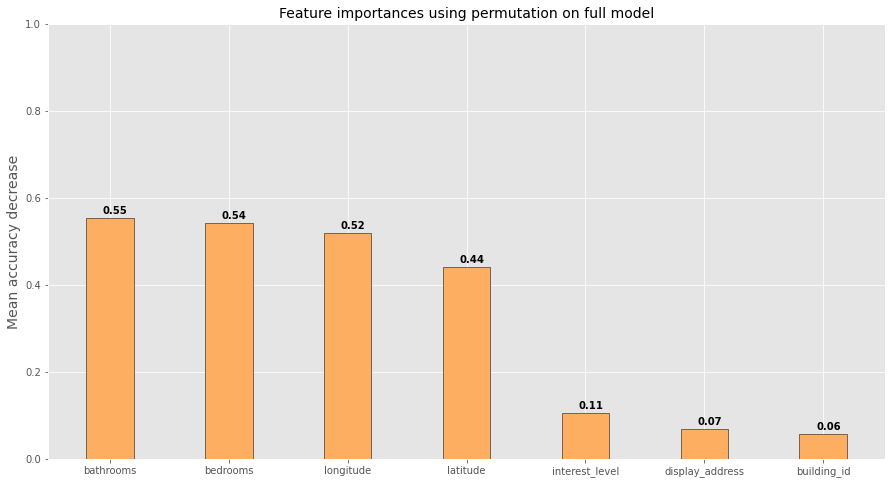

In [29]:
importances = calculate_feature_importances(rf_regressor, X.values, y, X.columns)
plot_importances(importances)

The feature importance plot shows that features `display_address` and `building_id` are not predictive.
We can conclude that, for this data set, label encoding and frequency encoding of high-cardinality categorical variables is not helpful. 
These encoding techniques could, however, be useful on other data set so it's worth learning them.

The apartment data set also has some variables that are both nonnumeric and noncategorical, `description` and `features`. 
Such arbitrary strings have no obvious numerical encoding, but we can extract bits of information from them to create new features. 
For example, an apartment with parking, doorman, dishwasher, and so on might fetch a higher price so let's synthesize some `boolean` features derived from string features.

In [30]:
dataset['description'] = dataset['description'].fillna(value = '')
dataset['description'] = dataset['description'].str.lower()        

dataset['features'] = dataset['features'].fillna(value = '')   # fill missing values with empty strings
dataset['features'] = dataset['features'].astype('str').str.lower() # normalize to lower case

In [31]:
dataset['renovated'] = dataset['description'].str.contains('renov')

for apartment_feature in ['doorman', 'parking', 'garage', 'laundry', 'elevator', 'fitness center', 'dishwasher']:
    dataset[apartment_feature] = dataset['features'].str.contains(apartment_feature)

There's not much we can do with the list of photo URLs in the `photos` string column, but the number of photos might be slightly predictive of price, so let's create a feature for that as well.

In [32]:
dataset["number_of_photos"] = dataset["photos"].astype('str').apply(lambda x: len(x.split(",")))
dataset = dataset.drop(labels = ['description', 'features', 'listing_id', 'photos', 'street_address'], axis = 1)

In [33]:
features = [
    'bathrooms', 'bedrooms', 'building_id', 'display_address',
    'latitude', 'longitude', 'manager_id', 'interest_level',  
    'renovated', 'doorman', 'parking', 'garage', 
    'laundry', 'elevator', 'fitness center', 'dishwasher', 
    'number_of_photos'
]

X, y = dataset[features].values, dataset['price'].values

rf_regressor = RandomForestRegressor(n_jobs = -1, oob_score = True)
rf_regressor.fit(X = X, y = y)

print(f'R^2 score: {rf_regressor.score(X = X, y = y)}, OOB score: {rf_regressor.oob_score_}')

R^2 score: 0.9812010741884876, OOB score: 0.871144504651341


As we can see, the accuracy of the model did not improve significantly meaning that these derived features are not strong predictors of price.
Nevertheless, it is worth learning about these techniques since they may be useful in for other problems.

Perhaps there is some predictive power in the ratio of bedrooms to bathrooms, so let's try synthesizing a new column that is the ratio of two numeric columns.

In [34]:
X, y = dataset[features], dataset['price']
X.assign(bedrooms_to_bathrooms_ratio = X['bedrooms'] / (X['bathrooms'] + 1))
X, y = X.values, y.values

rf_regressor = RandomForestRegressor(n_jobs = -1, oob_score = True)
rf_regressor.fit(X = X, y = y)

print(f'R^2 score: {rf_regressor.score(X = X, y = y)}, OOB score: {rf_regressor.oob_score_}')

R^2 score: 0.9811939520422599, OOB score: 0.870284486661953


Combining numerical columns is a useful technique to keep in mind, but unfortunately this combination doesn't affect our model significantly here.

**Notes**:

 - We show some techniques on how to explore and better understand the data.
 - We show how to denoise the data and deal with categorical data.
 - We explain OOB Random Forest score and feature importance calculation.